In [5]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, check_scoring
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import itertools
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

In [6]:
emotion_dict = {'angry': 0,
                'neutral': 1,
                'positive': 2,
                'sad': 3,
               }

emotion_encoder = LabelEncoder()
emotion_encoder.fit(list(emotion_dict.keys()))
def plot_confusion_matrix(cm, labels,title='Confusion matrix',
                          normalize=False,cmap=plt.cm.Blues):
    
    
    # plt.figure(figsize=(8,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='YlGnBu', 
                xticklabels=labels, yticklabels=labels)

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
        

def eval_results(y_test, pred_probs, cm=True):
    y_test_numeric = emotion_encoder.transform(y_test)
    y_pred = np.argmax(pred_probs, axis=-1)
    print(f'Test Set Accuracy: {accuracy_score(y_test_numeric, y_pred) * 100:.3f}%')
    print(f'Test Set F-score: {f1_score(y_test_numeric, y_pred, average="macro") * 100:.3f}%')
    print(f'Test Set Precision: {precision_score(y_test_numeric, y_pred, average="macro") * 100:.3f}%')
    print(f'Test Set Recall: {recall_score(y_test_numeric, y_pred, average="macro") * 100:.3f}%')
    if cm:
        cm_matrix = confusion_matrix(y_test_numeric, y_pred)
        plot_confusion_matrix(cm_matrix, labels=emotion_encoder.classes_)

In [7]:
def load_data_train_test(train_path, test_path):
    data_train = pd.read_csv(train_path)
    data_test = pd.read_csv(test_path)

    X_train = data_train.drop(['name', 'emotion'],axis = 1).values
    y_train = data_train['emotion'].values
    
    X_test = data_test.drop(['name', 'emotion'],axis = 1).values
    y_test = data_test['emotion'].values
    return X_train,y_train,X_test,y_test

# AUDIO

In [10]:
X_train,y_train,X_test,y_test = load_data_train_test(
    '/kaggle/input/v3features82crowd/audio_train_features.csv',
    '/kaggle/input/v3features82crowd/audio_test_features.csv'
)

Test Set Accuracy: 40.150%
Test Set F-score: 32.481%
Test Set Precision: 32.444%
Test Set Recall: 32.536%


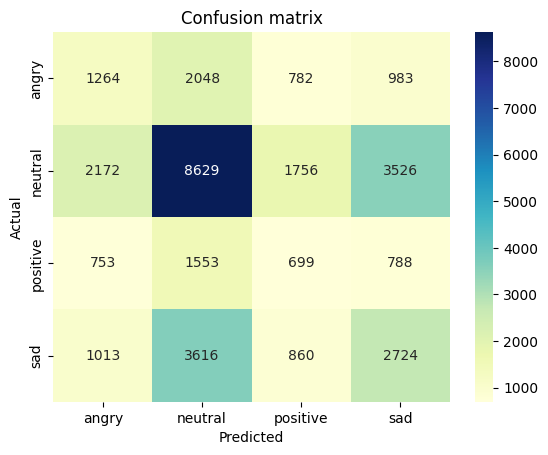

In [11]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict_proba(X_test)
eval_results(y_test,y_pred)

with open('/kaggle/working/decisiontree_mfcc.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

Test Set Accuracy: 54.447%
Test Set F-score: 32.041%
Test Set Precision: 63.345%
Test Set Recall: 33.568%


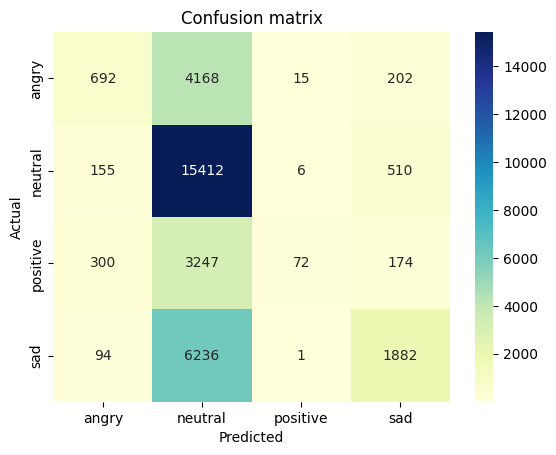

In [12]:
random_forest = RandomForestClassifier(n_estimators = 1200, min_samples_split = 25)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict_proba(X_test)
eval_results(y_test, y_pred)
with open('/kaggle/working/randomforest_mfcc.pkl','wb') as f:
    pickle.dump(y_pred, f)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:43:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy: 58.952%
Test Set F-score: 44.656%
Test Set Precision: 60.001%
Test Set Recall: 42.504%


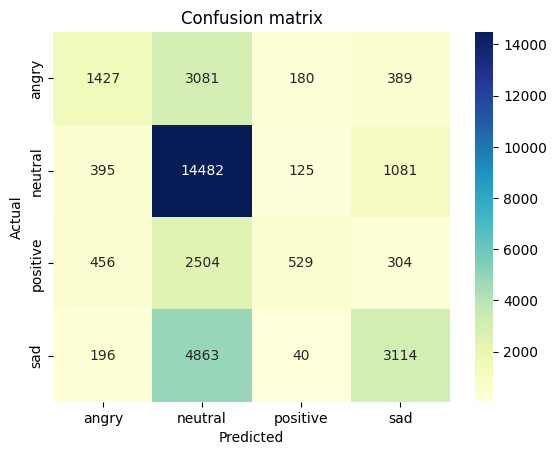

In [13]:
xgboost = xgb.XGBClassifier(max_depth = 7, learning_rate = 0.008, objective = 'multi:softprob',
                           n_estimators = 1200, sub_sample= 0.8, num_class = len(emotion_dict),
                           booster='gbtree', n_jobs = 4)
y_train_numeric = emotion_encoder.transform(y_train)

xgboost.fit(X_train, y_train_numeric)
y_pred = xgboost.predict_proba(X_test)

eval_results(y_test, y_pred)

with open('/kaggle/working/xgboost_mfcc.pkl', 'wb') as f:
    pickle.dump(y_pred,f)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Set Accuracy: 64.497%
Test Set F-score: 57.148%
Test Set Precision: 63.200%
Test Set Recall: 54.319%


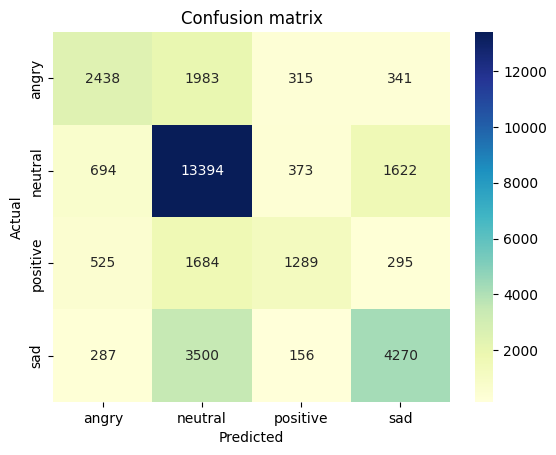

In [14]:
logistic = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter = 1000)
y_train_numeric = emotion_encoder.transform(y_train)
logistic.fit(X_train, y_train_numeric)
y_pred = logistic.predict_proba(X_test)

eval_results(y_test, y_pred)

with open('/kaggle/working/logistic_mfcc.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

Dữ liệu có giá trị âm, cần xử lý!
Test Set Accuracy: 19.601%
Test Set F-score: 16.381%
Test Set Precision: 35.579%
Test Set Recall: 28.015%


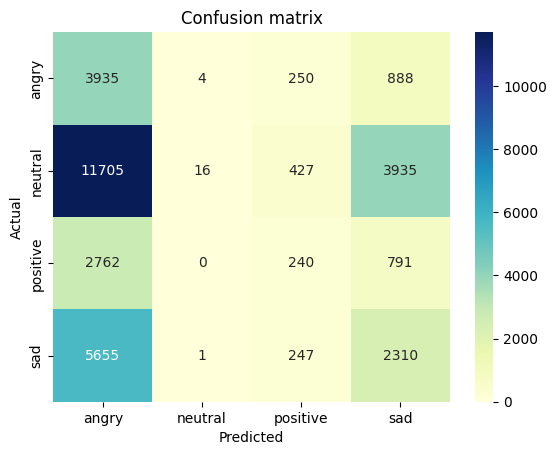

In [15]:
mnb = MultinomialNB()
if (X_train < 0).any():
    print("Dữ liệu có giá trị âm, cần xử lý!")
    X_train[X_train < 0] = 0  # Thay thế giá trị âm bằng 0
y_train_numeric = emotion_encoder.transform(y_train)
mnb.fit(X_train, y_train_numeric)
y_pred = mnb.predict_proba(X_test)
eval_results(y_test, y_pred)
with open('/kaggle/working/multinomialnb_mfcc.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

In [ ]:
svc = SVC(kernel = 'linear',probability = True)
svc.fit(X_train, y_train)
y_pred = svc.predict_proba(X_test)
eval_results(y_test, y_pred)

with open('/kaggle/working/svc_mfcc.pkl', 'wb') as f:
    pickle.dump(y_pred,f)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (650, ), activation='relu', solver='adam', alpha=0.0001,
                    batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                    power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                    verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                    epsilon=1e-08)
mlp.fit(X_train, y_train)
y_pred = mlp.predict_proba(X_test)
eval_results(y_test, y_pred)
with open('/kaggle/working/mlp_mfcc.pkl','wb') as f:
    pickle.dump(y_pred, f)

# TEXT

In [8]:
X_train,y_train,X_test,y_test = load_data_train_test(
    '/kaggle/input/v3features82crowd/text_train_features.csv',
    '/kaggle/input/v3features82crowd/text_test_features.csv'
)

Test Set Accuracy: 46.952%
Test Set F-score: 49.688%
Test Set Precision: 48.744%
Test Set Recall: 50.730%


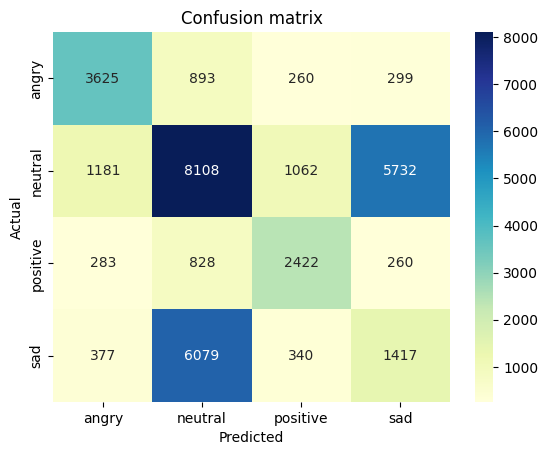

In [9]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict_proba(X_test)
eval_results(y_test,y_pred)

with open('/kaggle/working/decisiontree_mfcc.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

Test Set Accuracy: 54.122%
Test Set F-score: 54.008%
Test Set Precision: 60.548%
Test Set Recall: 51.110%


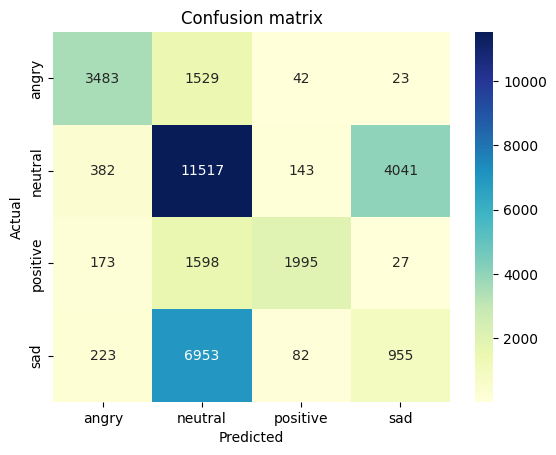

In [10]:
random_forest = RandomForestClassifier(n_estimators = 1200, min_samples_split = 25)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict_proba(X_test)
eval_results(y_test, y_pred)
with open('/kaggle/working/randomforest_mfcc.pkl','wb') as f:
    pickle.dump(y_pred, f)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:44:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy: 62.679%
Test Set F-score: 55.900%
Test Set Precision: 64.194%
Test Set Recall: 55.655%


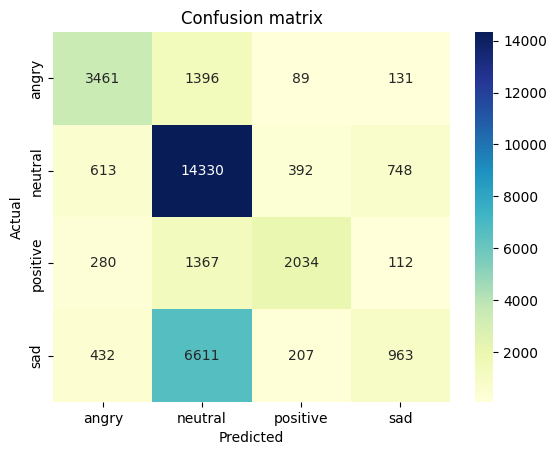

In [11]:
xgboost = xgb.XGBClassifier(max_depth = 7, learning_rate = 0.008, objective = 'multi:softprob',
                           n_estimators = 1200, sub_sample= 0.8, num_class = len(emotion_dict),
                           booster='gbtree', n_jobs = 4)
y_train_numeric = emotion_encoder.transform(y_train)

xgboost.fit(X_train, y_train_numeric)
y_pred = xgboost.predict_proba(X_test)

eval_results(y_test, y_pred)

with open('/kaggle/working/xgboost_mfcc.pkl', 'wb') as f:
    pickle.dump(y_pred,f)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Set Accuracy: 61.328%
Test Set F-score: 54.276%
Test Set Precision: 59.980%
Test Set Recall: 54.505%


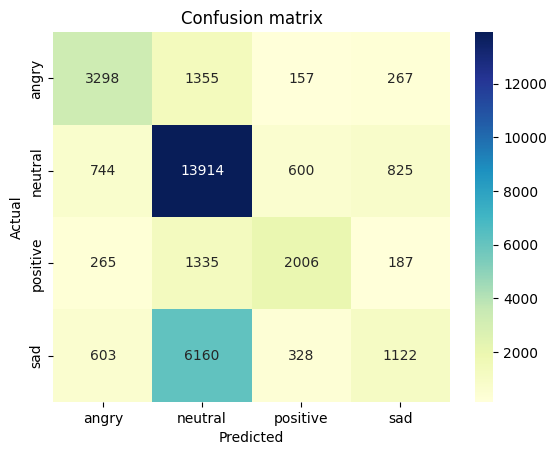

In [12]:
logistic = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter = 1000)
y_train_numeric = emotion_encoder.transform(y_train)
logistic.fit(X_train, y_train_numeric)
y_pred = logistic.predict_proba(X_test)

eval_results(y_test, y_pred)

with open('/kaggle/working/logistic_mfcc.pkl', 'wb') as f:
    pickle.dump(y_pred, f)